In [1]:
import torch
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from nn import FunctionModel, save_model, load_model
import copy
import matplotlib.pyplot as plt
from model_training import train,pinn_loss,build_rightside


In [47]:
ndim = 3
gamma = 1
kbt = .1
lam = 10
eta = gamma*kbt
omega = gamma
sigma = 1/0.3

args = {
        "ndim": ndim,
        "gamma": gamma,
        "kbt": kbt,
        "lam": lam,
        "eta": eta,
        "omega": omega
    }


# sample 
Nx_sample = 1000000
Nv_sample = 1000000
NA = 10
NB = 10
Nxb_sample=100
Nvb_sample=100

batch_size = 2048 #not implement

layers = [2*ndim,20,20,20,20,1]
activ  = 'sigmoid'

alpha_t = 1
T = 200
Nt = int(T/alpha_t)
Nsteps = 20
lr = 1e-3

device = torch.device(
                "cuda" if torch.cuda.is_available() else "cpu")

x1 = (torch.rand(size=(int(Nx_sample*0.1),1),dtype=torch.float32))*2-1
x111 = torch.rand(size = (int(Nx_sample*0.9),1),dtype=torch.float32)*0.8-0.4
x1 = torch.cat((x1,x111),dim = 0)
print(x1.shape)
xm1 = torch.randn(size=(Nx_sample,ndim-1),dtype=torch.float32)*sigma*np.sqrt(kbt)
x = torch.concatenate((x1,xm1),dim=1)
v = torch.randn(size=(Nv_sample,ndim),dtype = torch.float32)*np.sqrt(kbt)
#data = torch.cat((x.repeat_interleave(Nv_sample,dim=0),v.repeat(Nx_sample,1)),dim=1)
data = torch.cat((x,v),dim=1)
w = torch.ones(size=(data.shape[0],1),device = device,dtype = torch.float32)
w = w/torch.sum(w)

def dU_func(x):
    dU = torch.zeros_like(x)
    dU[:,0] = 4*(x[:,0]**2-1)*x[:,0]
    dU[:,1:] = x[:,1:]/sigma**2
    return dU
dU = dU_func(data[:,:ndim])

vb = torch.randn(size=(Nvb_sample,ndim),dtype=torch.float32)*np.sqrt(kbt)
xA1 = torch.tensor([-1-0.1*i for i in range(NA)],dtype=torch.float32).unsqueeze(-1)
xAm1 = torch.randn(size=(Nxb_sample,ndim-1),dtype=torch.float32)*sigma*np.sqrt(kbt)
xA = torch.cat((xA1.repeat_interleave(Nxb_sample,dim=0),xAm1.repeat(NA,1)),dim=1)
xA = torch.cat((xA.repeat_interleave(Nvb_sample,dim=0),vb.repeat(Nxb_sample*NA,1)),dim=1)

xB1 = torch.tensor([1+0.1*i for i in range(NB)],dtype=torch.float32).unsqueeze(-1)
xBm1 = torch.randn(size=(Nxb_sample,ndim-1),dtype=torch.float32)*sigma*np.sqrt(kbt)
xB = torch.cat((xB1.repeat_interleave(Nxb_sample,dim=0),xBm1.repeat(NB,1)),dim=1)
xB = torch.cat((xB.repeat_interleave(Nvb_sample,dim=0),vb.repeat(NB*Nxb_sample,1)),dim=1)
labelA = 0*torch.ones_like(xA[:,0])
labelB = 1*torch.ones_like(xB[:,0])

data_b = torch.cat((xA,xB),dim=0)
label_b = torch.cat((labelA,labelB),dim=0).unsqueeze(dim=1)
print(label_b.shape)
del xA,xB,labelA,labelB

q = FunctionModel(layer_sizes=layers,activation=activ)
#model_file = f'./model/gamma10_kbt0.5_1I.pth'
#config_file = f'./config/gamma10_kbt0.5_1I.txt'
#q = load_model(model_file,config_file)


    

torch.Size([1000000, 1])
torch.Size([200000, 1])


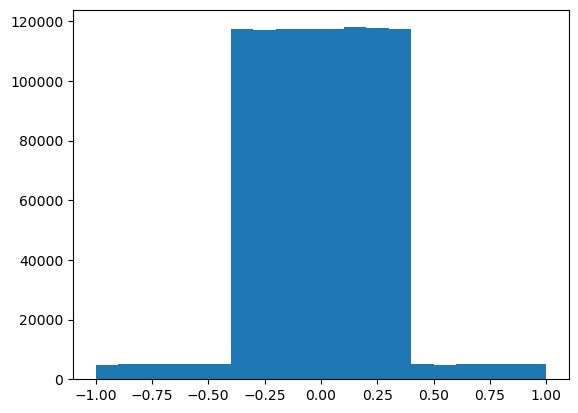

In [3]:
plt.hist(x1.squeeze().numpy(),bins=20)
plt.show()

In [48]:
args['lam'] = .2
args['eta'] = .2
args['omega'] = gamma

In [49]:
## initialize

q.to(device)

batch_size = 2**22
#eta = 10
lr = 1e-3
# kbt = 1
loss_list,b_loss_list,tot_loss_list,pinn_loss_list=train(model=q,
                                          data=data,
                                          w=w,
                                          batchsize=batch_size,
                                          data_b=data_b,
                                          label_b=label_b,
                                          alpha_b=100,
                                          lr = lr,
                                          num_tsteps=100,
                                          num_epoches=Nsteps,
                                          device=device,
                                          args=args,
                                          dU=dU,
                                          checkpoint=10,
                                          adaptive=False)

itr0: Building dataset!
itr0: Training!
itr0: Training completed!
itr1: Building dataset!
itr1: Training!
itr1: Training completed!
itr2: Building dataset!
itr2: Training!
itr2: Training completed!
itr3: Building dataset!
itr3: Training!
itr3: Training completed!
itr4: Building dataset!
itr4: Training!
itr4: Training completed!
itr5: Building dataset!
itr5: Training!
itr5: Training completed!
itr6: Building dataset!
itr6: Training!
itr6: Training completed!
itr7: Building dataset!
itr7: Training!
itr7: Training completed!
itr8: Building dataset!
itr8: Training!
itr8: Training completed!
itr9: Building dataset!
itr9: Training!
itr9: Training completed!
itr10: Building dataset!
itr10: Training!
itr10: Training completed!
itr11: Building dataset!
itr11: Training!
itr11: Training completed!
itr12: Building dataset!
itr12: Training!
itr12: Training completed!
itr13: Building dataset!
itr13: Training!
itr13: Training completed!
itr14: Building dataset!
itr14: Training!
itr14: Training comple

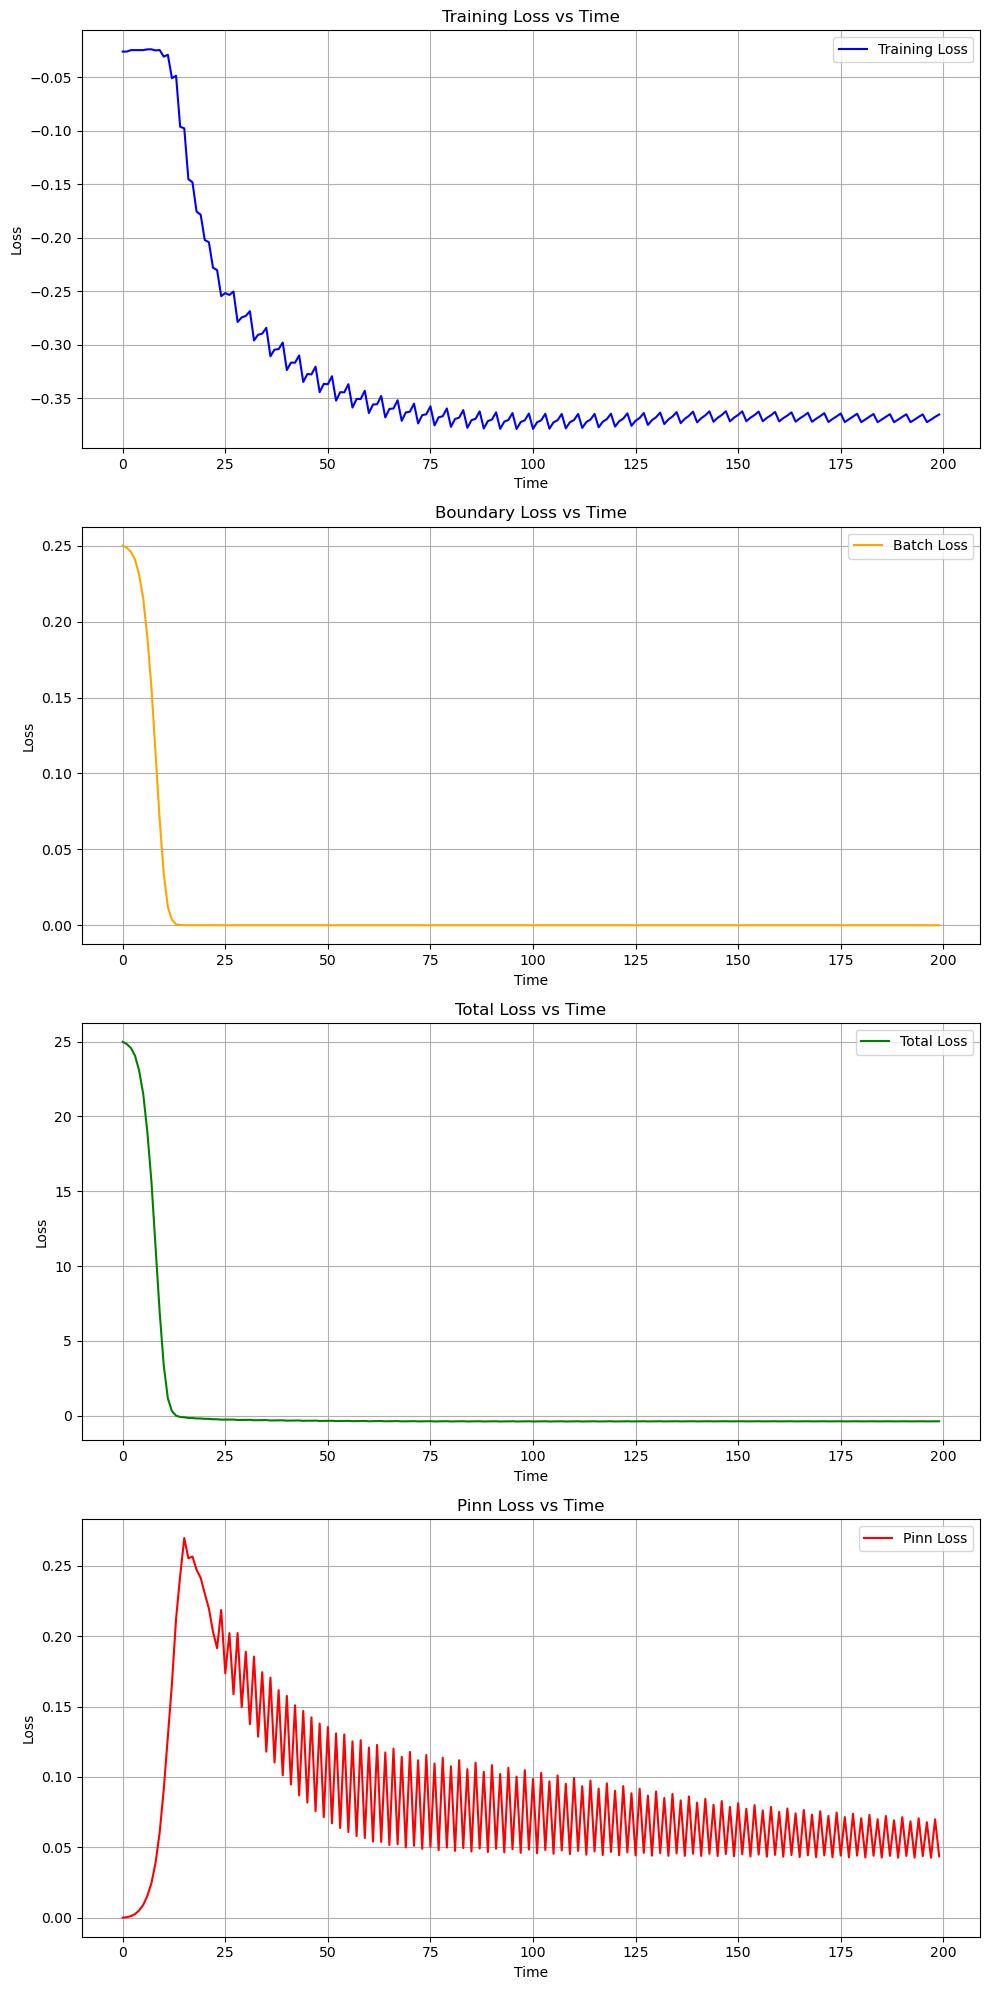

In [50]:
t = np.arange(len(loss_list))  # Time values  


# Create a figure with 3 subplots  
fig, axs = plt.subplots(4, 1, figsize=(10, 20))  

# Plot training loss  
axs[0].plot(t, loss_list, label='Training Loss', color='blue')  
axs[0].set_title('Training Loss vs Time')  
axs[0].set_xlabel('Time')  
axs[0].set_ylabel('Loss')  
axs[0].legend()  
axs[0].grid()  

# Plot batch loss  
axs[1].plot(t, b_loss_list, label='Batch Loss', color='orange')  
axs[1].set_title('Boundary Loss vs Time')  
axs[1].set_xlabel('Time')  
axs[1].set_ylabel('Loss')  
axs[1].legend()  
axs[1].grid()  

# Plot total loss  
axs[2].plot(t, tot_loss_list, label='Total Loss', color='green')  
axs[2].set_title('Total Loss vs Time')  
axs[2].set_xlabel('Time')  
axs[2].set_ylabel('Loss')  
axs[2].legend()  
axs[2].grid()  

axs[3].plot(t, pinn_loss_list, label='Pinn Loss', color='red')  
axs[3].set_title('Pinn Loss vs Time')  
axs[3].set_xlabel('Time')  
axs[3].set_ylabel('Loss')  
axs[3].legend()  
axs[3].grid() 

# Adjust layout  
plt.tight_layout()  
plt.show()  

In [7]:
args['lam'] = 1
args['eta'] = 1
args['omega'] = 5*gamma

In [76]:

data.requires_grad_(True)
q.to(device)
data = data.to(device)
batch_size = 2**22
#eta = 10
lr = 1e-5*5
#eta = 1
#lam = 1
#kbt = .5
loss_list,b_loss_list,tot_loss_list,pinn_loss_list=train(model=q,
                                          data=data,
                                          w=w,
                                          batchsize=batch_size,
                                          data_b=data_b,
                                          label_b=label_b,
                                          alpha_b=100,
                                          lr = lr,
                                          num_tsteps=Nt,
                                          num_epoches=40,
                                          device=device,
                                          args=args,
                                          dU=dU,
                                          checkpoint=10,
                                          adaptive=False)


itr0: Building dataset!
itr0: Training!
itr0: Training completed!
itr1: Building dataset!
itr1: Training!
itr1: Training completed!
itr2: Building dataset!
itr2: Training!
itr2: Training completed!
itr3: Building dataset!
itr3: Training!
itr3: Training completed!
itr4: Building dataset!
itr4: Training!
itr4: Training completed!
itr5: Building dataset!
itr5: Training!
itr5: Training completed!
itr6: Building dataset!
itr6: Training!
itr6: Training completed!
itr7: Building dataset!
itr7: Training!
itr7: Training completed!
itr8: Building dataset!
itr8: Training!
itr8: Training completed!
itr9: Building dataset!
itr9: Training!
itr9: Training completed!
itr10: Building dataset!
itr10: Training!
itr10: Training completed!
itr11: Building dataset!
itr11: Training!
itr11: Training completed!
itr12: Building dataset!
itr12: Training!
itr12: Training completed!
itr13: Building dataset!
itr13: Training!
itr13: Training completed!
itr14: Building dataset!
itr14: Training!
itr14: Training comple

In [75]:
args

{'ndim': 3, 'gamma': 1, 'kbt': 0.1, 'lam': 0.2, 'eta': 0.2, 'omega': 1}

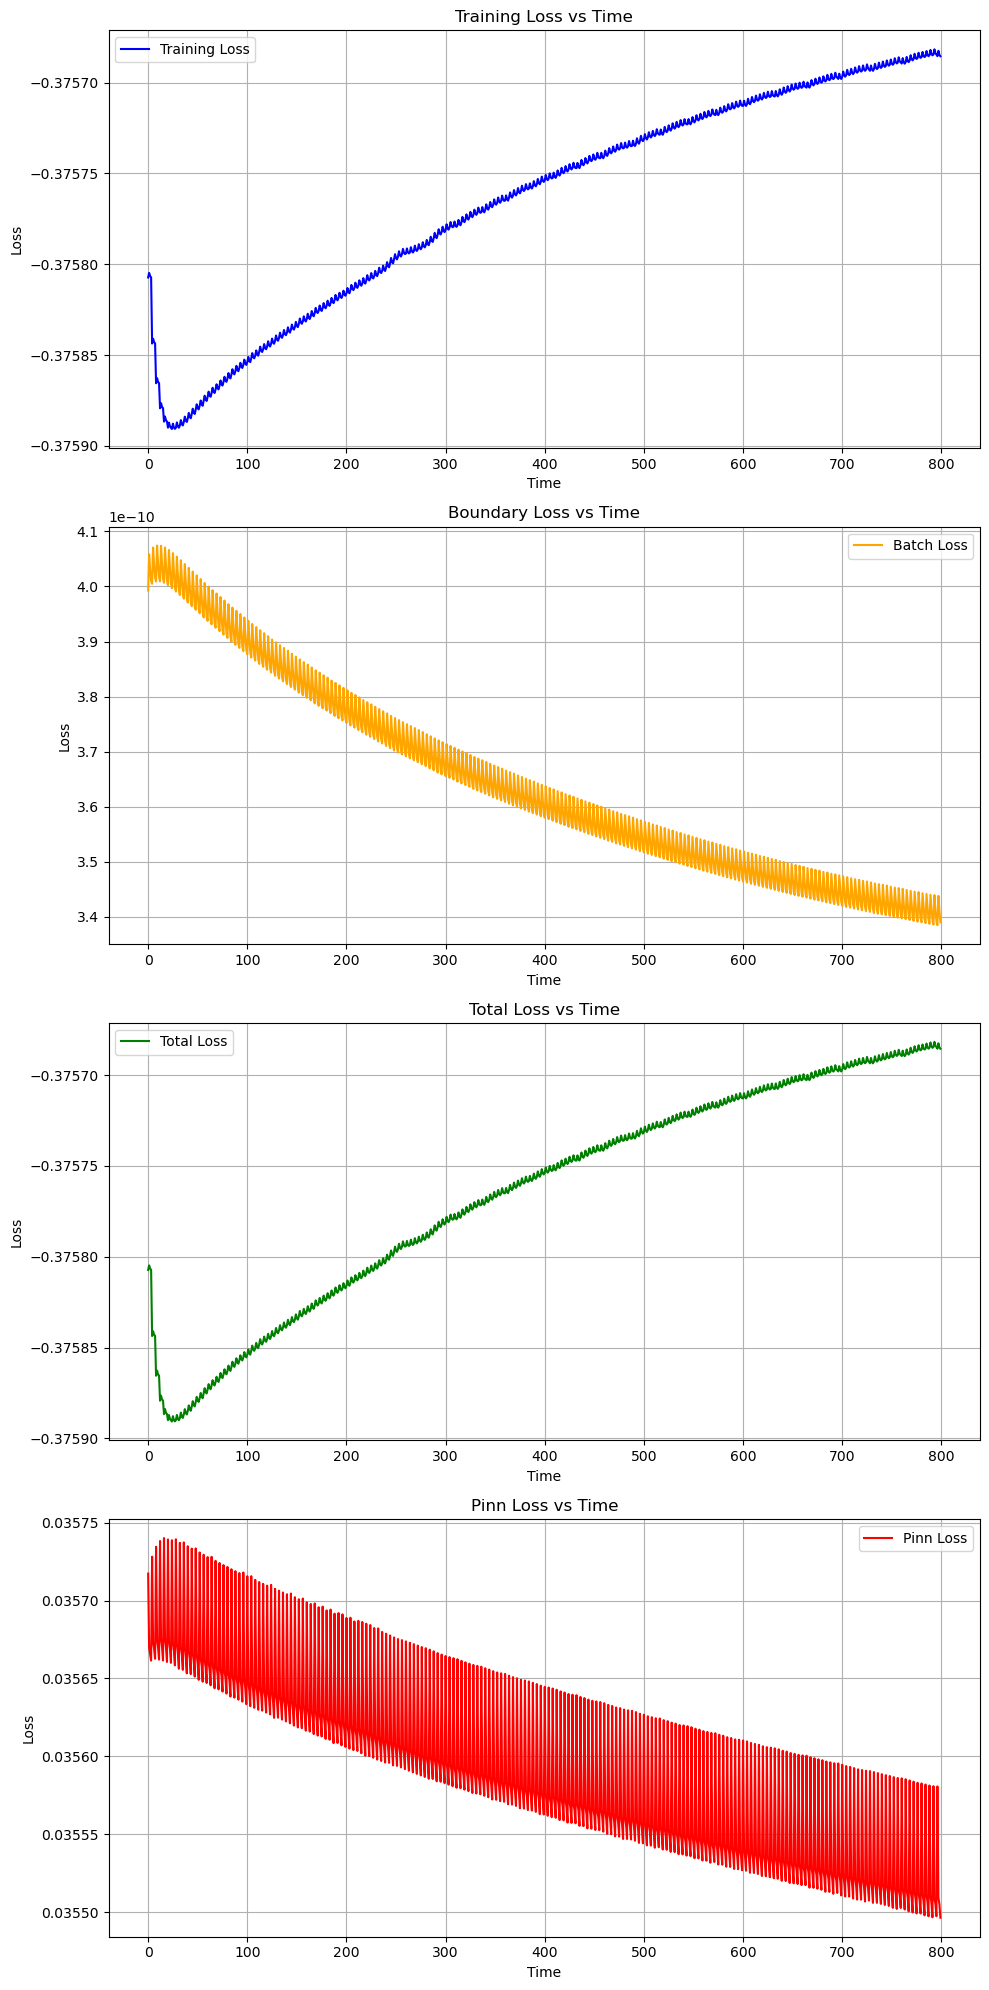

In [77]:
t = np.arange(len(loss_list))  # Time values  


# Create a figure with 3 subplots  
fig, axs = plt.subplots(4, 1, figsize=(10, 20))  

# Plot training loss  
axs[0].plot(t, loss_list, label='Training Loss', color='blue')  
axs[0].set_title('Training Loss vs Time')  
axs[0].set_xlabel('Time')  
axs[0].set_ylabel('Loss')  
axs[0].legend()  
axs[0].grid()  

# Plot batch loss  
axs[1].plot(t, b_loss_list, label='Batch Loss', color='orange')  
axs[1].set_title('Boundary Loss vs Time')  
axs[1].set_xlabel('Time')  
axs[1].set_ylabel('Loss')  
axs[1].legend()  
axs[1].grid()  

# Plot total loss  
axs[2].plot(t, tot_loss_list, label='Total Loss', color='green')  
axs[2].set_title('Total Loss vs Time')  
axs[2].set_xlabel('Time')  
axs[2].set_ylabel('Loss')  
axs[2].legend()  
axs[2].grid()  

axs[3].plot(t, pinn_loss_list, label='Pinn Loss', color='red')  
axs[3].set_title('Pinn Loss vs Time')  
axs[3].set_xlabel('Time')  
axs[3].set_ylabel('Loss')  
axs[3].legend()  
axs[3].grid() 

# Adjust layout  
plt.tight_layout()  
plt.show()  

In [19]:
data.requires_grad_(True)
q.to(device)
data = data.to(device)
batch_size = 2**22
#eta = 10
lr = 1e-4
#eta = 1
#lam = 1
#kbt = .5
loss_list,b_loss_list,tot_loss_list,pinn_loss_list=train(model=q,
                                          data=data,
                                          w=w,
                                          batchsize=batch_size,
                                          data_b=data_b,
                                          label_b=label_b,
                                          alpha_b=100,
                                          lr = lr,
                                          num_tsteps=Nt*2,
                                          num_epoches=40,
                                          device=device,
                                          args=args,
                                          dU=dU,
                                          checkpoint=10,
                                          adaptive=False)


itr0: Building dataset!
itr0: Training!
itr0: Training completed!
itr1: Building dataset!
itr1: Training!
itr1: Training completed!
itr2: Building dataset!
itr2: Training!
itr2: Training completed!
itr3: Building dataset!
itr3: Training!
itr3: Training completed!
itr4: Building dataset!
itr4: Training!
itr4: Training completed!
itr5: Building dataset!
itr5: Training!
itr5: Training completed!
itr6: Building dataset!
itr6: Training!
itr6: Training completed!
itr7: Building dataset!
itr7: Training!
itr7: Training completed!
itr8: Building dataset!
itr8: Training!
itr8: Training completed!
itr9: Building dataset!
itr9: Training!
itr9: Training completed!
itr10: Building dataset!
itr10: Training!
itr10: Training completed!
itr11: Building dataset!
itr11: Training!
itr11: Training completed!
itr12: Building dataset!
itr12: Training!
itr12: Training completed!
itr13: Building dataset!
itr13: Training!
itr13: Training completed!
itr14: Building dataset!
itr14: Training!
itr14: Training comple

In [20]:
print(args['lam'],args['eta'],args['omega'])

0.2 0.2 1


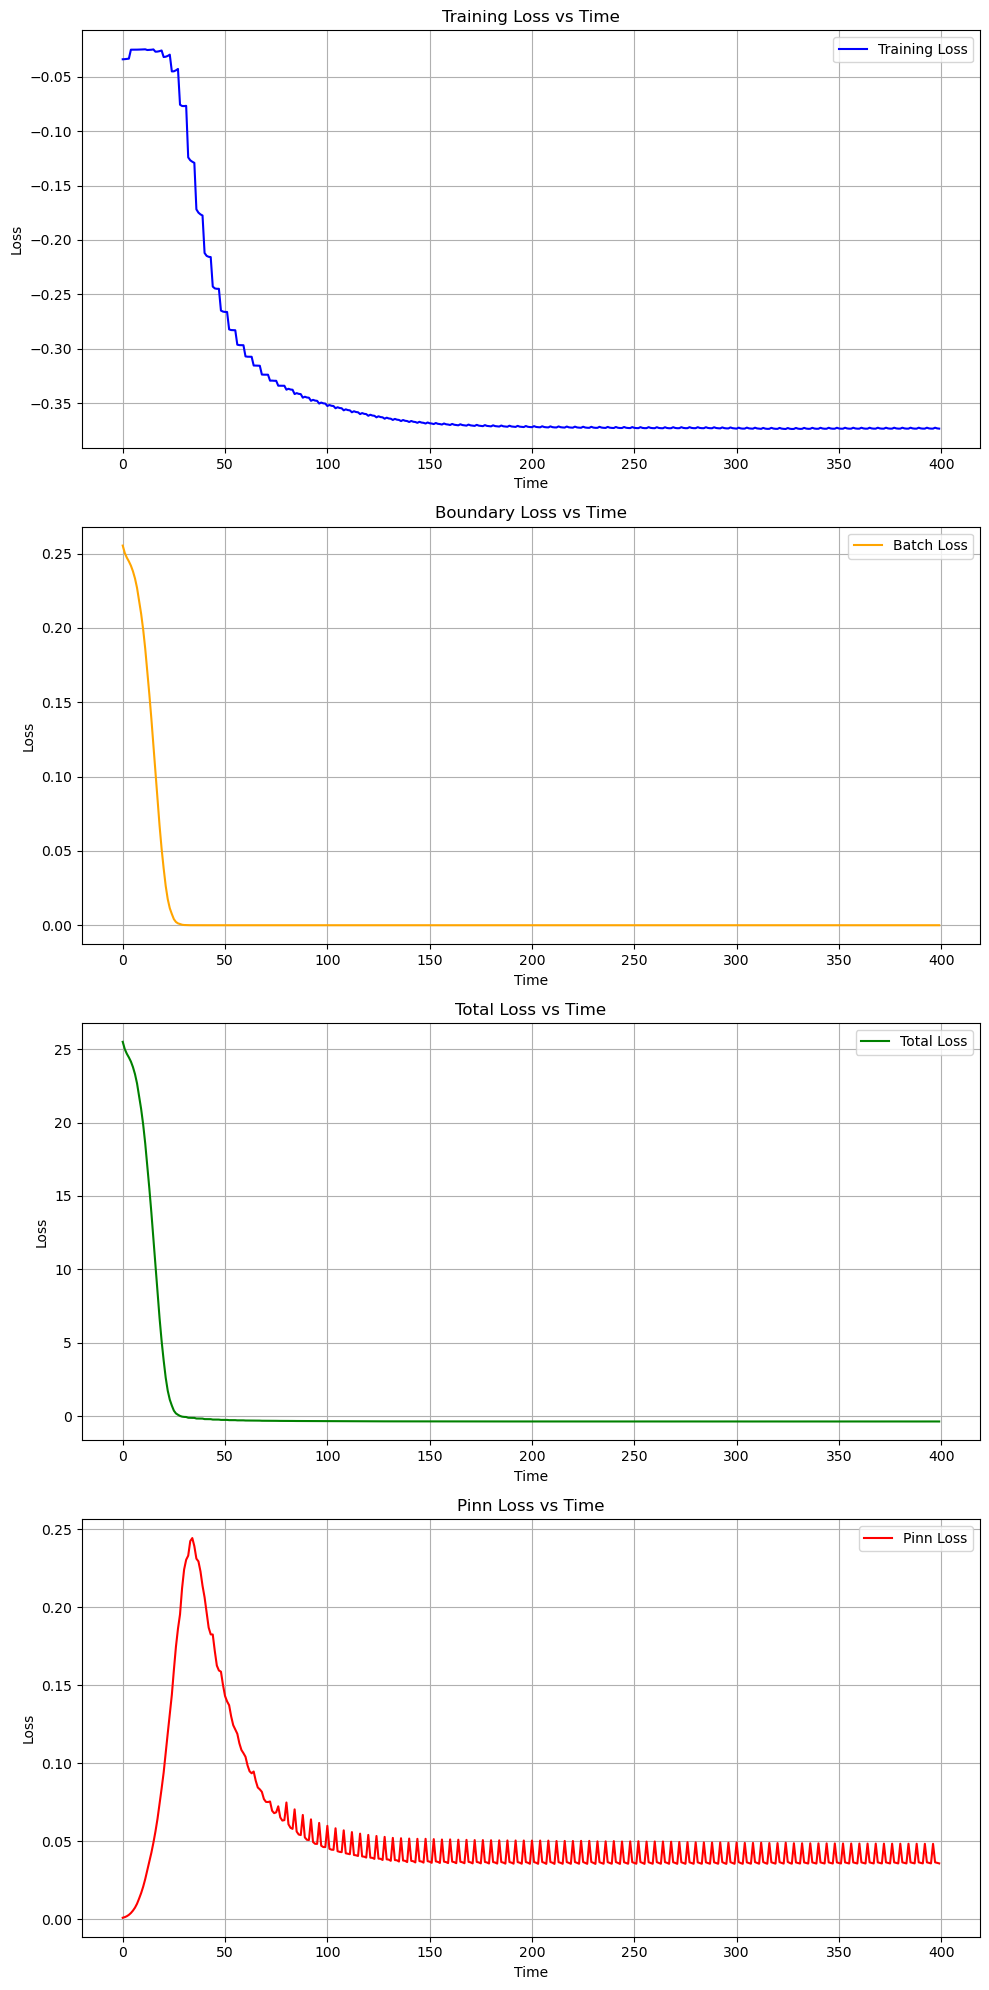

In [43]:
t = np.arange(len(loss_list))  # Time values  


# Create a figure with 3 subplots  
fig, axs = plt.subplots(4, 1, figsize=(10, 20))  

# Plot training loss  
axs[0].plot(t, loss_list, label='Training Loss', color='blue')  
axs[0].set_title('Training Loss vs Time')  
axs[0].set_xlabel('Time')  
axs[0].set_ylabel('Loss')  
axs[0].legend()  
axs[0].grid()  

# Plot batch loss  
axs[1].plot(t, b_loss_list, label='Batch Loss', color='orange')  
axs[1].set_title('Boundary Loss vs Time')  
axs[1].set_xlabel('Time')  
axs[1].set_ylabel('Loss')  
axs[1].legend()  
axs[1].grid()  

# Plot total loss  
axs[2].plot(t, tot_loss_list, label='Total Loss', color='green')  
axs[2].set_title('Total Loss vs Time')  
axs[2].set_xlabel('Time')  
axs[2].set_ylabel('Loss')  
axs[2].legend()  
axs[2].grid()  

axs[3].plot(t, pinn_loss_list, label='Pinn Loss', color='red')  
axs[3].set_title('Pinn Loss vs Time')  
axs[3].set_xlabel('Time')  
axs[3].set_ylabel('Loss')  
axs[3].legend()  
axs[3].grid() 

# Adjust layout  
plt.tight_layout()  
plt.show()  

In [22]:
q.to(device)

FunctionModel(
  (layers): ModuleList(
    (0): Linear(in_features=6, out_features=8, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=8, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [22]:
xmin, xmax = -1, 1
vmin, vmax = -3*np.sqrt(kbt), 3*np.sqrt(kbt)
dx = 0.001
dv = 0.01*np.sqrt(kbt)
Nx = int((xmax - xmin) / dx)
Nv = int((vmax - vmin) / dv)


Ncol = Nx - 1
Nrow = Nv + 1
x = np.linspace(xmin, xmax, Nx + 1)
x=x.astype(np.float32)
v = np.linspace(vmin, vmax, Nv + 1)

if Ncol == Nx - 1:
    xcal = x[1:-1]
else:
    xcal = x

if Nrow == Nv - 1:
    vcal = v[1:-1]
else:
    vcal = v


X, V = np.meshgrid(xcal, vcal)
# print(X.shape, V)

points = np.array([X.reshape(-1), V.reshape(-1)]).T.astype(np.float32)
'''
c = np.arange(len(points))
plt.scatter(points[:, 0], points[:, 1], c=c)
plt.colorbar()
plt.show()
'''
N_matrix = Nrow * Ncol
ddd = torch.zeros((len(points),2*ndim),dtype=torch.float32)
ddd[:,[0,ndim]] = torch.from_numpy(points)

xxm1 = torch.randn(size=(1,ndim-1))*np.sqrt(kbt)*sigma
vvm1 = torch.randn(size=(1,ndim-1))*np.sqrt(kbt)
ddd[:,(ndim+1):] = vvm1
ddd[:,1:ndim] = xxm1
ddd = ddd.to(device)
qqq = q(ddd).squeeze().to('cpu').detach()





In [23]:
fd = np.loadtxt(f'./model/fd_g{gamma}_kbt{kbt}.txt')
q0 = np.loadtxt(f'./model/fd_g.5_kbt{kbt}_q0.txt')
q_simulation = np.loadtxt('./model/q_s_1d.txt')

In [24]:
qmean = np.zeros_like(q0)
NNN = 10000
ddd = torch.zeros(size=(NNN,2*ndim),dtype=torch.float32)
for i in range(qmean.shape[0]):
    
    ddd[:,ndim:] = torch.randn(size=(NNN,ndim),dtype=torch.float32)*np.sqrt(kbt)
    ddd[:,1:ndim] = torch.randn(size=(NNN,ndim-1),dtype=torch.float32)*np.sqrt(kbt)*sigma
    ddd[:,0] = xcal[i]*torch.ones_like(ddd[:,0])
    qqq = q(ddd.to(device))
    qmean[i] = qqq.mean().item()



In [51]:
ddd = torch.zeros((len(points),2*ndim),dtype=torch.float32)
ddd[:,[0,ndim]] = torch.from_numpy(points)

xxm1 = torch.randn(size=(1,ndim-1))*np.sqrt(kbt)*sigma
vvm1 = torch.randn(size=(1,ndim-1))*np.sqrt(kbt)
ddd[:,(ndim+1):] = vvm1
ddd[:,1:ndim] = xxm1
ddd = ddd.to(device)
qqq = q(ddd).squeeze().to('cpu').detach()

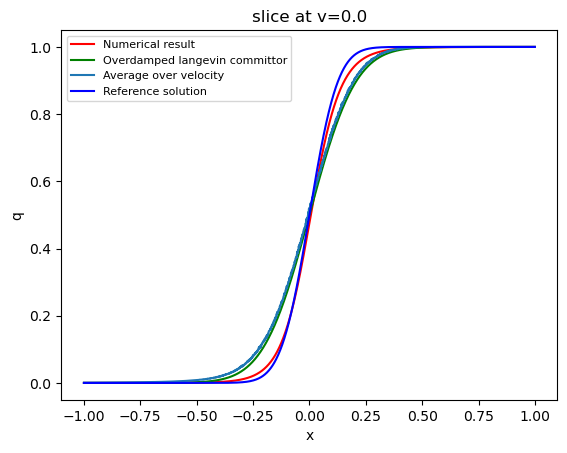

In [52]:
vslice = 0.0
Q = qqq.reshape(X.shape)
Qfd = fd[:,2].reshape(X.shape)
#plt.plot(xcal[::10], Q[int((vslice-vmin)/dv), ::10]-Qfd[int((vslice-vmin)/dv), ::10])
#plt.plot(xcal[:], Q[int((vslice-vmin)/dv), :]-Qfd[int((vslice-vmin)/dv), :])
plt.plot(xcal[:], Q[int((vslice-vmin)/dv), :],'r',label = 'Numerical result')
plt.plot(xcal[:], q0,'g',label = 'Overdamped langevin committor')
plt.plot(xcal[:], qmean,label = 'Average over velocity')
plt.plot(xcal[:],Qfd[int((vslice-vmin)/dv), :],'b',label='Reference solution')
#plt.plot(xcal, Q[int((vslice-vmin)/dv), :])
plt.xlabel('x')
plt.ylabel('q')
plt.legend(loc = 'upper left',fontsize=8)
plt.title(f'slice at v={vslice}')
plt.show()

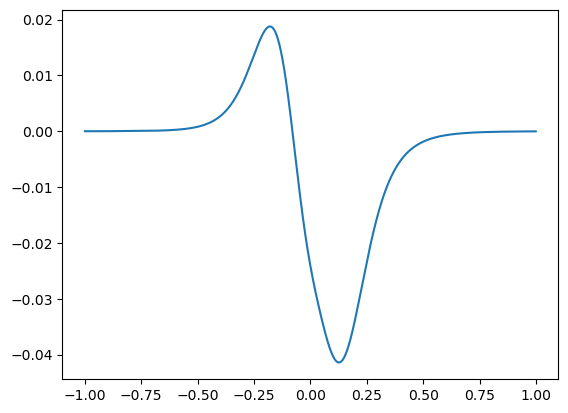

In [53]:
plt.plot(xcal[:], Q[int((vslice-vmin)/dv), :]-Qfd[int((vslice-vmin)/dv), :])
plt.show()

In [ ]:
mm=5
nn=5
fig, axs = plt.subplots(mm, nn, figsize=(mm*7, nn*5))  
fig1, axs1 = plt.subplots(mm, nn, figsize=(mm*7, nn*5)) 
q.to(device)
ddd = torch.zeros(size = (fd.shape[0],2*ndim),device = device,dtype = torch.float32)
ddd[:,[0,ndim]] = torch.from_numpy(fd[:,0:2].astype(np.float32)).to(device)
# Generate random data for each subplot  
for i in range(mm):  
    for j in range(nn):  
        idx = j+nn*i
        print(idx)
        '''
        ddd.requires_grad_(False)
        ddd[:,(ndim):] = vvm1
        ddd.requires_grad_(True)
        dU1 = potential.gradient(ddd[:,:ndim])
        pinn_l = pinn_loss(q(ddd),ddd,dU1,args)
        pinn_l = pinn_l.detach().cpu().numpy()
        qqq1 = q(ddd).squeeze().to('cpu').detach() 
        '''
        vvm1 = torch.randn(size=(1,ndim-1),dtype = torch.float32,device=device).to(device)*np.sqrt(kbt)
        ddd[:,(ndim+1):] = vvm1
        xxm1 = torch.randn(size=(1,ndim-1),dtype = torch.float32,device=device).to(device)*sigma*np.sqrt(kbt)
        ddd[:,1:ndim] = xxm1
        qqq = q(ddd).squeeze().to('cpu').detach().numpy() 
        
        # Create scatter plot  
        sc=axs[i, j].scatter(points[:,0],points[:,1],c=qqq)  
        sc1 = axs1[i, j].scatter(points[:,0],points[:,1],c=np.abs(qqq-fd[:,2]))  
        axs[i, j].set_title(f'committor at slice {idx+1}')  
        axs[i, j].set_xlabel('x')  
        axs[i, j].set_ylabel('v')
        axs1[i, j].set_title(f'residue at slice {idx+1}')  
        axs1[i, j].set_xlabel('x')  
        axs1[i, j].set_ylabel('v')
        fig.colorbar(sc, ax=axs[i,j])
        fig1.colorbar(sc1, ax=axs1[i,j])



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [ ]:
'''
plt.scatter(simulation[:,0],simulation[:,1],c=simulation[:,2])
plt.colorbar()
plt.show()
'''

'\nplt.scatter(simulation[:,0],simulation[:,1],c=simulation[:,2])\nplt.colorbar()\nplt.show()\n'

In [ ]:
qmean = np.zeros_like(q0)
NNN = 10000
ddd = torch.zeros(size=(NNN,2*ndim),dtype=torch.float32)
for i in range(qmean.shape[0]):
    
    ddd[:,ndim:] = torch.randn(size=(NNN,ndim),dtype=torch.float32)*np.sqrt(kbt)
    ddd[:,1:ndim] = torch.randn(size=(NNN,ndim-1),dtype=torch.float32)*np.sqrt(kbt)*sigma
    ddd[:,0] = xcal[i]*torch.ones_like(ddd[:,0])
    qqq = q(ddd.to(device))
    qmean[i] = qqq.mean().item()



In [ ]:
ddd = torch.zeros((len(points),2*ndim),dtype=torch.float32)
ddd[:,[0,ndim]] = torch.from_numpy(points)

xxm1 = torch.randn(size=(1,ndim-1))*np.sqrt(kbt)*sigma
vvm1 = torch.randn(size=(1,ndim-1))*np.sqrt(kbt)
ddd[:,(ndim+1):] = vvm1
ddd[:,1:ndim] = xxm1
ddd = ddd.to(device)
qqq = q(ddd).squeeze().to('cpu').detach().numpy()

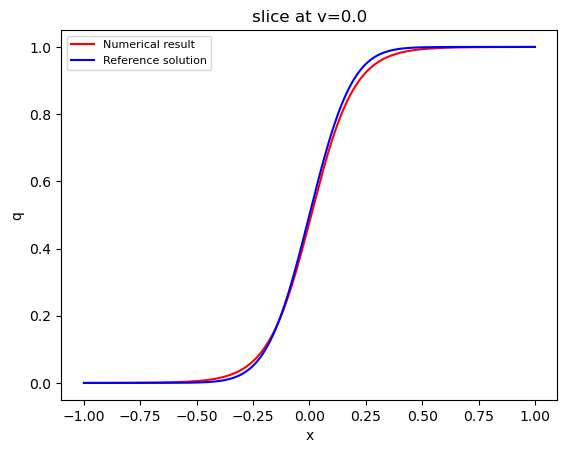

In [ ]:
vslice = 0.0
Q = qqq.reshape(X.shape)
Qfd = fd[:,2].reshape(X.shape)
#plt.plot(xcal[::10], Q[int((vslice-vmin)/dv), ::10]-Qfd[int((vslice-vmin)/dv), ::10])
#plt.plot(xcal[:], Q[int((vslice-vmin)/dv), :]-Qfd[int((vslice-vmin)/dv), :])
plt.plot(xcal[:], Q[int((vslice-vmin)/dv), :],'r',label = 'Numerical result')
#plt.plot(xcal[:], q0,'g',label = 'Overdamped langevin committor')
#plt.plot(xcal[:], qmean,label = 'Average over velocity')
plt.plot(xcal[:],Qfd[int((vslice-vmin)/dv), :],'b',label='Reference solution')
#plt.plot(xcal, Q[int((vslice-vmin)/dv), :])
plt.xlabel('x')
plt.ylabel('q')
plt.legend(loc = 'upper left',fontsize=8)
plt.title(f'slice at v={vslice}')
plt.show()

In [ ]:
model_file = f'./model/gamma{gamma}_kbt{kbt}.pth'
config_file = f'./config/gamma{gamma}_kbt{kbt}.txt'
save_model(q,model_file,config_file)

Model saved to ./config/gamma25_kbt10.txt
Model saved to ./model/gamma25_kbt10.pth
